In [1]:
# imports
from scipy.stats import multivariate_normal, multinomial
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

In [2]:
class Mixture:
    __slots__ = "dim", "K", "pis", "mus", "sigmas"
    
    def __init__(self, pis, mus, sigmas):
        if not np.isclose(sum(pis), 1): raise ValueError("Pi's do not add to 1!")
        self.K = len(pis)
        self.pis = pis
        self.mus = mus
        self.sigmas = sigmas
        self.dim, _ = sigmas[0].shape
        
    def sample(self, n):
        C = np.argmax(multinomial.rvs(1, self.pis, size=n), axis=1)
        
        X = np.zeros(shape=(n, self.dim))
        for i, c in enumerate(C):
            X[i, :] = multivariate_normal.rvs(mean=self.mus[c], cov=self.sigmas[c])
        return X
    
    def pdf(self, X):
        pdf = np.zeros(len(X))
        
        for i, x in enumerate(X):
            prob = 0
            for k in range(self.K):
                prob += self.pis[k] * multivariate_normal.pdf(x, mean=self.mus[k], cov=self.sigmas[k])
            pdf[i] = prob
            
        return pdf

In [3]:
def EM_Algorithm(X, K, mu_0, T=1000):
    # set algorithm parameters
    N, dim = X.shape
    
    # initialize parameters
    pis = np.full(fill_value=1/K, shape=K)
    mus = mu_0
    sigmas = [np.diag(np.ones(dim),0) for _ in range(K)]
    
    # overall loop
    for _ in range(T):
        # expectation step
        gammas = np.zeros((N, K))
        for k in range(K):
            # this might be double dipping our likelihood
            gammas[:, k] = pis[k] * multivariate_normal.pdf(x=X, mean=mus[k], cov=sigmas[k])
        gammas = gammas / gammas.sum(axis=1, keepdims=True)

        # maximization step
        for k in range(K):
            mus[k] = np.sum(gammas[:, k][:, np.newaxis] * X, axis=0) / np.sum(gammas[:, k])
            sigmas[k] = np.dot((gammas[:, k][:, np.newaxis] * (X - mus[k])).T, (X - mus[k])) / np.sum(gammas[:, k])
            pis[k] = np.mean(gammas[:, k], axis=0)
            
    # order the estimates
    ind = np.argsort(pis)
    
    # return final parameter estimations
    return np.array(pis)[ind], np.array(mus)[ind], np.array(sigmas)[ind]

# One Dimension

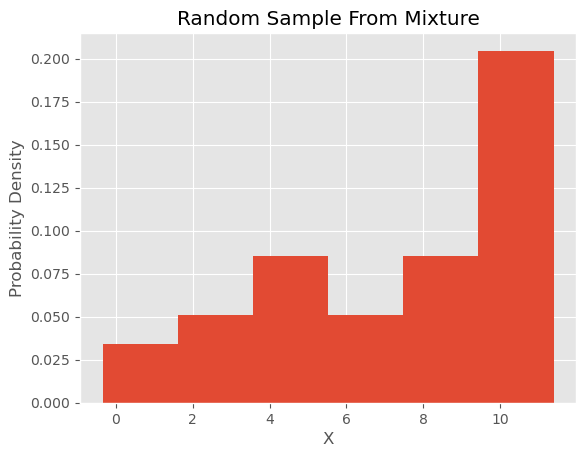

In [6]:
dim = 1
pis = [0.2, 0.5, 0.3]
mus = [np.array([0]), np.array([5]), np.array([10])]
sigmas = [np.diag(np.ones(dim),0), 2 * np.diag(np.ones(dim),0), np.diag(np.ones(dim),0)]

mixture = Mixture(pis, mus, sigmas)
X = mixture.sample(30)

plt.hist(X, density=True, bins="auto")
plt.title("Random Sample From Mixture")
plt.xlabel("X")
plt.ylabel("Probability Density")
plt.show()

In [7]:
# define the number of clusters
K = len(pis)

# run kmeans to get an estimate for the mus
kmeans = KMeans(n_clusters=K, n_init="auto")
kmeans.fit(X)
mu_0 = kmeans.cluster_centers_

# display the estimated means
print(mu_0)

[[9.85333157]
 [5.23537722]
 [0.34320014]]


In [8]:
pis_hat, mus_hat, sigmas_hat = EM_Algorithm(X=X, K=K, mu_0=mu_0, T=1000)
mixture_hat = Mixture(pis_hat, mus_hat, sigmas_hat)

print("estimated pis:\n", pis_hat)
print("estimated mus:\n", mus_hat)
print("estimated sigmas:\n", sigmas_hat)

estimated pis:
 [0.21307577 0.37034343 0.4165808 ]
estimated mus:
 [[10.58144033]
 [ 9.16576582]
 [ 4.11413734]]
estimated sigmas:
 [array([[0.0098306]]), array([[1.51111485]]), array([[6.75029361]])]


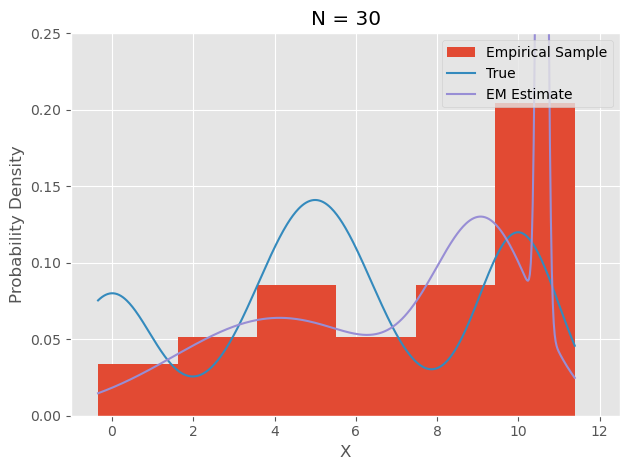

In [9]:
# define the x-axis for the plot
x_axis = np.linspace(min(X), max(X), 500)

# add the histogram of data points
plt.hist(X, bins="auto", density=True, label="Empirical Sample")

# add the true pdf
plt.plot(x_axis, mixture.pdf(x_axis), label="True")

# add the estimated pdf
plt.plot(x_axis, mixture_hat.pdf(x_axis), label="EM Estimate")

# style and display the plot
plt.title("N = 30")
plt.xlabel("X")
plt.ylabel("Probability Density")
plt.xlim([-1, 12.5])
plt.ylim([0, 0.25])
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

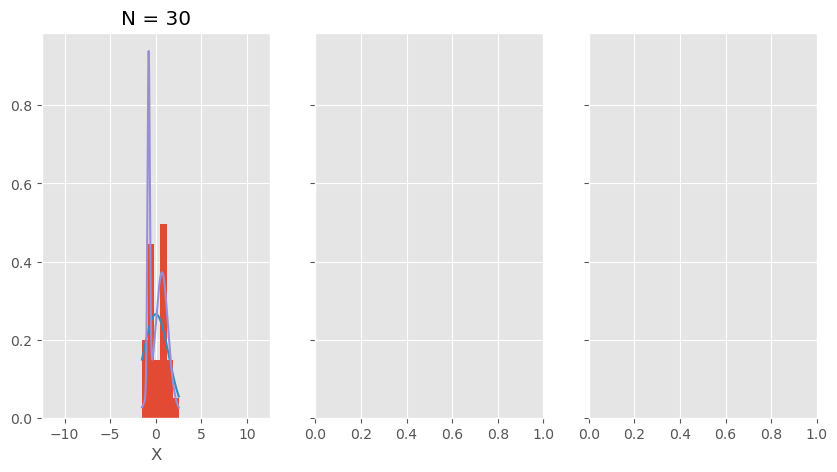

In [10]:
dim = 1
pis = [0.01, 0.94, 0.05]
mus = [np.array([-7.5]), np.array([0]), np.array([7.5])]
sigmas = [2*np.diag(np.ones(dim),0), 2*np.diag(np.ones(dim),0), 2*np.diag(np.ones(dim),0)]

# sample the distribution
mixture = Mixture(pis, mus, sigmas)
samples = mixture.sample(1000)

fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

for i, n in enumerate([30, 100, 1000]):
    
    # define the amount of data to use
    X = samples[:n]

    # define the number of clusters
    K = len(pis)

    # run kmeans to get an estimate for the mus
    kmeans = KMeans(n_clusters=K, n_init="auto")
    kmeans.fit(X)
    mu_0 = kmeans.cluster_centers_

    pis_hat, mus_hat, sigmas_hat = EM_Algorithm(X=X, K=K, mu_0=mu_0, T=1000)
    mixture_hat = Mixture(pis_hat, mus_hat, sigmas_hat)

    # define the x-axis for the plot
    x_axis = np.linspace(min(X), max(X), 500)

    # add the histogram of data points
    axs[i].hist(X, bins="auto", density=True, label="Empirical Sample")

    # add the true pdf
    axs[i].plot(x_axis, mixture.pdf(x_axis), label="True")

    # add the estimated pdf
    axs[i].plot(x_axis, mixture_hat.pdf(x_axis), label="EM Estimate")

    # style and display the plot
    axs[i].set_title(f"N = {n}")
    axs[i].set_xlabel("X")
    axs[i].set_xlim([-12.5, 12.5])
    
    
axs[0].set_ylabel("Probability Density")
axs[2].legend(loc="upper right")
# save the figure
plt.savefig(f'/Users/colbys-p/Desktop/SampleSizes', dpi=300)
plt.show()

# Two Dimensions

In [ ]:
dim = 2
pis = [0.33, 0.34, 0.33]
mus = [np.array([-10, 0]), np.array([0, 5]), np.array([10, 0])]
sigmas = [np.diag(np.ones(dim),0), np.diag(np.ones(dim),0), np.diag(np.ones(dim),0)]

mixture = Mixture(pis, mus, sigmas)
X = mixture.sample(500)

plt.scatter(X[:, 0], X[:, 1], label='Sampled Data')
plt.title("Random Sample From Mixture")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('scaled')
plt.legend()
plt.show()

In [ ]:
# define the number of clusters
K = len(pis)

# run kmeans to get an estimate for the mus
kmeans = KMeans(n_clusters=K, n_init="auto")
kmeans.fit(X)
mu_0 = kmeans.cluster_centers_

# display the estimated means
print(mu_0)

In [ ]:
pis_hat, mus_hat, sigmas_hat = EM_Algorithm(X=X, K=K, mu_0=mu_0, T=1000)
mixture_hat = Mixture(pis_hat, mus_hat, sigmas_hat)

print("estimated pis:\n", pis_hat)
print("estimated mus:\n", mus_hat)
print("estimated sigmas:\n", sigmas_hat)

### True Joint PDF

In [ ]:
# compute the probabilities at each grid point
res = 100
grid_x = np.linspace(min(X[:, 0]) * 1.1, max(X[:, 0]) * 1.1, res)
grid_y = np.linspace(min(X[:, 1]) * 1.1, max(X[:, 1]) * 1.1, res)
grid_X, grid_Y = np.meshgrid(grid_x, grid_y)

points = np.zeros(shape=(res ** 2, 2))
points[:, 0] = grid_X.ravel()
points[:, 1] = grid_Y.ravel()

grid_Z = mixture.pdf(points)
grid_Z = grid_Z.reshape(grid_X.shape)

In [ ]:
# make filled contour plot of probability densities
plt.scatter(X[:, 0], X[:, 1], c="k", s=10)
plt.contourf(grid_X, grid_Y, grid_Z, levels=20, cmap='viridis', alpha=0.4)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('True Gaussian Mixture Model PDF')
plt.show()

### Estimated Joint PDF

In [ ]:
# compute the probabilities at each grid point
res = 100
grid_x = np.linspace(min(X[:, 0]) * 1.1, max(X[:, 0]) * 1.1, res)
grid_y = np.linspace(min(X[:, 1]) * 1.1, max(X[:, 1]) * 1.1, res)
grid_X, grid_Y = np.meshgrid(grid_x, grid_y)

points = np.zeros(shape=(res ** 2, 2))
points[:, 0] = grid_X.ravel()
points[:, 1] = grid_Y.ravel()

grid_Z = mixture_hat.pdf(points)
grid_Z = grid_Z.reshape(grid_X.shape)

In [ ]:
# make filled contour plot of probability densities
plt.scatter(X[:, 0], X[:, 1], c="k", s=10)
plt.contourf(grid_X, grid_Y, grid_Z, levels=20, cmap='viridis', alpha=0.4)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Estimated Gaussian Mixture Model PDF')
plt.show()

# Plot True and Estimated

In [39]:
# set true parameters
dim = 2
pis = [0.1, 0.5, 0.4]
mus = [np.array([-5, 0]), np.array([0, 5]), np.array([0, 0])]
sigmas = [np.array([[1, 0], [0, 5]]), 2*np.diag(np.ones(dim),0), np.array([[2, -1.3], [-1.3, 2]])]

# generate true mixture distribution
mixture = Mixture(pis, mus, sigmas)

# set seed and sample gaussian mixture
np.random.seed(100)
X = mixture.sample(1000)

# run kmeans to get an estimate for the mus
kmeans = KMeans(n_clusters=len(pis), n_init="auto")
kmeans.fit(X)
mu_0 = kmeans.cluster_centers_

# estimate the parameters
pis_hat, mus_hat, sigmas_hat = EM_Algorithm(X=X, K=K, mu_0=mu_0, T=1000)
mixture_hat = Mixture(pis_hat, mus_hat, sigmas_hat)

# show the estiamted parameters
print("estimated pis:\n", pis_hat)
print("estimated mus:\n", mus_hat)
print("estimated sigmas:\n", sigmas_hat)

estimated pis:
 [0.31577409 0.36875936 0.31546655]
estimated mus:
 [[-1.98592975  2.53021884]
 [ 0.1452121   5.19638403]
 [ 0.24837642 -0.2339931 ]]
estimated sigmas:
 [array([[6.61145947, 3.7984263 ],
       [3.7984263 , 7.49362529]]), array([[ 1.63670559, -0.19634671],
       [-0.19634671,  1.41161516]]), array([[ 1.63416847, -1.13847421],
       [-1.13847421,  1.98302519]])]


In [40]:
# construct the mesh grid
res = 100
grid_x = np.linspace(-8, 4.5, res)
grid_y = np.linspace(-5, 10, res)
grid_X, grid_Y = np.meshgrid(grid_x, grid_y)

# format points in a way compatable with the mixture distribution
points = np.zeros(shape=(res ** 2, 2))
points[:, 0] = grid_X.ravel()
points[:, 1] = grid_Y.ravel()

# compute the pdf value for each point in grid
true_Z = mixture.pdf(points).reshape(grid_X.shape)
est_Z = mixture_hat.pdf(points).reshape(grid_X.shape)

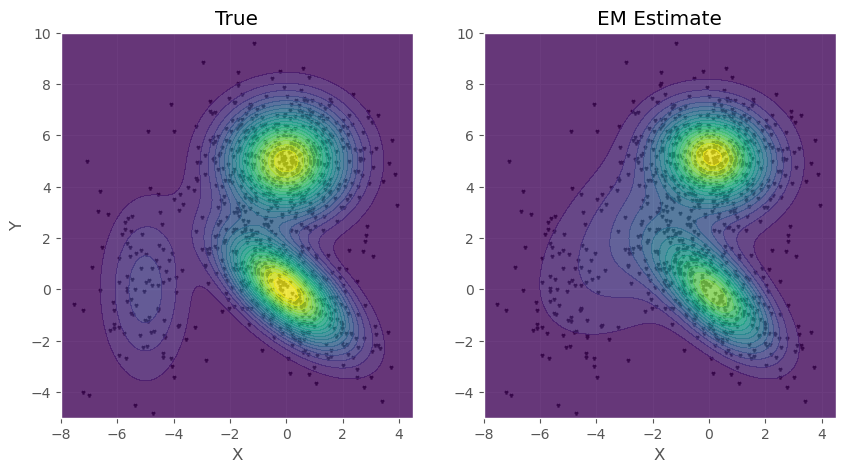

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(X[:, 0], X[:, 1], c="k", s=10, marker="1")
axs[0].contourf(grid_X, grid_Y, true_Z, levels=20, cmap='viridis', alpha=0.8)

axs[1].scatter(X[:, 0], X[:, 1], c='k', s=10, marker="1")
axs[1].contourf(grid_X, grid_Y, est_Z, levels=20, cmap='viridis', alpha=0.8)

# set consistent x and y axis limits
axs[0].set_xlim([-8, 4.5])
axs[1].set_xlim([-8, 4.5])
axs[0].set_ylim([-5, 10])
axs[1].set_ylim([-5, 10])

# label the axis
axs[0].set_ylabel("Y")
axs[0].set_xlabel("X")
axs[1].set_xlabel("X")
axs[0].set_title('True')
axs[1].set_title('EM Estimate')

# save the figure
# plt.savefig(f'/Users/colbys-p/Desktop/2DMixtureLarge', dpi=300)
plt.show()

# 10-D Mixture MSE Computation

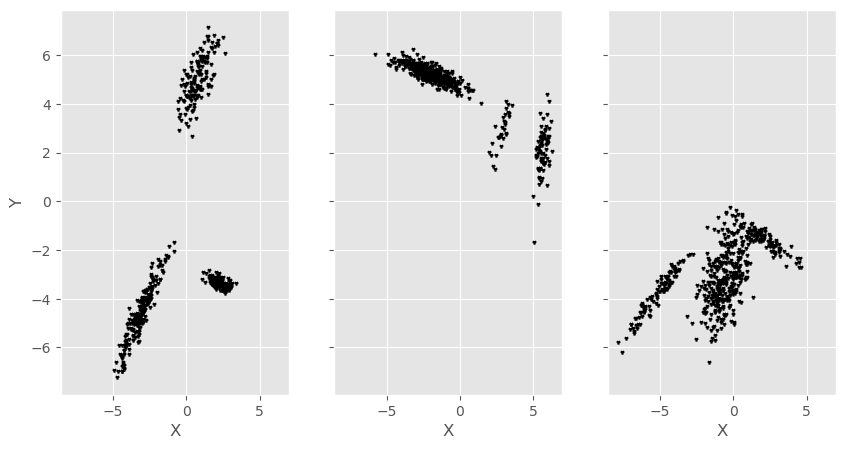


The Dimensionality is 2:
0.11218800734858654
4.816951124812404
2.119265686027986


In [41]:
np.random.seed(0)

for dim in range(2, 3):
    
    # set simulation parameters and placeholder arrays
    K = 3
    N = 500
    pi_error = []
    mu_error = []
    sigma_error = []

    # loop N times to compute the MSE given 500 samples
    fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
    fig_num = 0
    for i in range(20):

        # sometimes the computation fails due to singular matricies
        try:

            # generate random parameters for the gaussian mixture
            pis = np.random.dirichlet(np.ones(K), size=1).flatten()
            mus = np.random.uniform(-6, 6, size=(K, dim))
            sigmas = []
            for j in range(K):
                A = 2 * (np.random.random((dim, dim)) - 0.5)
                sigmas.append(np.dot(A.T, A))
            sigmas = np.array(sigmas)

            # sort them so that there is consistency
            ind = np.argsort(pis)
            pis = pis[ind]
            mus = mus[ind]
            sigmas = sigmas[ind]

            # make the theoretical distribution
            mixture = Mixture(pis, mus, sigmas)

            # sample mixture dist
            X = mixture.sample(500)
            
            """plt.title(f"{i}")
            plt.scatter(X[:, 0], X[:, 1], c="k", s=10, marker="1")
            plt.show()"""

            # make figure of sample randomly generated gaussians
            if i in [1, 12, 19] and dim == 2:

                axs[fig_num].scatter(X[:, 0], X[:, 1], c="k", s=10, marker="1")

                # set consistent x and y axis limits
                # axs[i].set_xlim([-6, 6])
                # axs[i].set_ylim([-6, 6])

                # label the axis
                axs[0].set_ylabel("Y")
                axs[fig_num].set_xlabel("X")
                
                fig_num += 1

            # run kmeans to get an estimate for the mus
            kmeans = KMeans(n_clusters=len(pis), n_init="auto")
            kmeans.fit(X)
            mu_0 = kmeans.cluster_centers_

            # estimate the parameters
            pis_hat, mus_hat, sigmas_hat = EM_Algorithm(X=X, K=K, mu_0=mu_0, T=1000)
            mixture_hat = Mixture(pis_hat, mus_hat, sigmas_hat)

            pi_error.append(np.linalg.norm(pis-pis_hat))
            mu_error.append(np.linalg.norm(mus-mus_hat))
            sigma_error.append(np.linalg.norm(sigmas-sigmas_hat))

        except:
            pass
        
    plt.savefig(f'/Users/colbys-p/Desktop/RandGauss', dpi=300)
    plt.show()
    print(f"\nThe Dimensionality is {dim}:")
    print(np.mean(pi_error))
    print(np.mean(mu_error))
    print(np.mean(sigma_error))

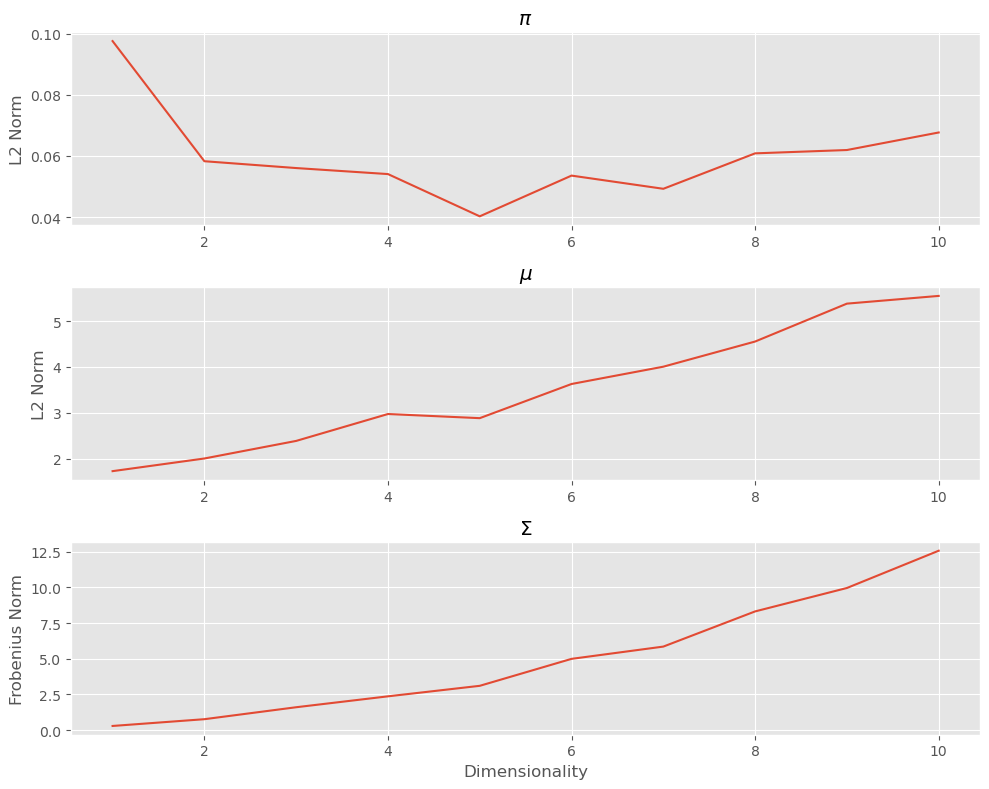

In [9]:
pi_mse = [0.09752394788726236, 0.05825454205534048, 0.05602124714564407, 0.05405365010859761, 0.040240492310217875, 0.053554297241224486, 0.049242054216347295, 0.060826780012502656, 0.06191555391634567, 0.06764933222293083]
mu_mse = [1.7341515864969022, 2.009455805671103, 2.391797963784747, 2.977018835550672, 2.8868235806461517, 3.6300848957378373, 4.00661520830052, 4.5539741599567005, 5.378395862679501, 5.5464731209491624]
sigma_mse = [0.2919881719930099, 0.7658204011986772, 1.6040768872495683, 2.36803901493038, 3.104456242782013, 4.993569730207922, 5.853394956396273, 8.318378691583757, 9.959016724450846, 12.57068754895459]

fig, axs = plt.subplots(3, 1, figsize=(10, 8))
axs[0].plot(np.arange(1, 11), pi_mse)
axs[1].plot(np.arange(1, 11), mu_mse)
axs[2].plot(np.arange(1, 11), sigma_mse)

axs[0].set_ylabel("L2 Norm")
axs[1].set_ylabel("L2 Norm")
axs[2].set_ylabel("Frobenius Norm")

axs[0].set_title(r"$\pi$")
axs[1].set_title(r"$\mu$")
axs[2].set_title(r"$\Sigma$")

plt.xlabel("Dimensionality")
plt.tight_layout()
plt.savefig(f'/Users/colbys-p/Desktop/MSEFigure', dpi=300)
plt.show()